# Проект №10 - Модель прогнозирования оттока клиентов фитнес-центра

## Описание проекта

Проанализировать поведение пользователей на основе анкет пользователей, их покупок, выявить группы пользователей и различной вероятность ухода в отток, разработать модель прогнозирования оттока пользователей, подготовить рекомендации по удержанию клиентов.

---
## <a id='oglav'>ОГЛАВЛЕНИЕ</a>

**[Шаг 1 - Загрузка данных](#upload)**<br>
**[Шаг 2 - EDA - исследовательский анализ данных](#eda)**<br>
 * 2.1 [Изучение общих данных датасета](#2.1)<br>
 * 2.2 [Изучение данных датасета с разбивкой по оттоку](#2.2)<br>
 * 2.3 [Матрица корреляции](#corr_matrix)<br>

**[Шаг 3 - Модель прогнозирования оттока пользователей](#model)**<br>
 * 3.1 [Модель бинарной классификации](#3.1)
 * 3.2 [Разбивка выборки на обучающую и валидационную](#3.2)
 * 3.3 [Обучение моделей](#3.3)
 * 3.4 [Выбор наилучшей модели по метрикам (accuracy, precision, recall)](#3.4)

**[Шаг 4 - Кластеризация пользователей](#cluster)**<br>
 * 4.1 [Уберём целевую переменную из датафрейма](#4.1)
 * 4.2 [Cтандартизируем признаки в новом датасете](#4.2)
 * 4.3 [Построим матрицу расстояний и построим дендрограмму](#4.3)
 * 4.4 [Кластеризация K-Means](#4.4)
 * 4.5 [Посмотрим на средние значения признаков по кластерам K-Means](#4.5)
 * 4.6 [Построим графики для кластеров](#4.6)
 * 4.7 [Доли оттока для кластеров](#4.7)
 
**[Шаг 5 - Выводы и рекомендации](#resume)**<br>

---

## <a class='anchor' id='upload'>Шаг 1 - Загрузка данных</a>

[К оглавлению](#oglav)

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score

from sklearn.cluster import KMeans, AgglomerativeClustering#, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
# выводить на экран все колонки датафрейма
pd.options.display.max_columns=999
# отобразить большие числа без плавающей точки
pd.set_option('display.float_format', lambda x: '%.2f' % x)
# отключаем назойливые предупреждения
warnings.filterwarnings('ignore')

In [3]:
try:
    link = 'gym_churn.csv'
    df = pd.read_csv(link)
except:
    link = '/datasets/gym_churn.csv'
    df = pd.read_csv(link)   
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Все значения датасета - числовые (датасет подготовлен, как и обещали). Пропусков нет. Всего 4000 записей (пользователей).

In [5]:
# переведём названия признаков в нижний регистр
df.columns = df.columns.str.lower()

In [6]:
df['month_to_end_contract'] = df['month_to_end_contract'].astype('int')

In [7]:
df.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.23,5,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1,3,1.11,1.12,0


In [8]:
# Разделим все колонки на разные группы в зависимости от значений в них
binar_cols = []; category_cols = []; numeric_cols = [] # бинарные, категориальные и числовые
binar_cols = df.iloc[:,[*map(lambda col: df[col].nunique()<=2, df.columns)]].columns
category_cols = df.iloc[:,[*map(lambda col: (df[col].nunique()>2)&(df[col].dtype=='int'), df.columns)]].columns
numeric_cols = df.iloc[:,[*map(lambda col: (df[col].nunique()>2)&(df[col].dtype=='float'), df.columns)]].columns

display(binar_cols, category_cols, numeric_cols)

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'group_visits', 'churn'],
      dtype='object')

Index(['contract_period', 'age', 'month_to_end_contract', 'lifetime'], dtype='object')

Index(['avg_additional_charges_total', 'avg_class_frequency_total',
       'avg_class_frequency_current_month'],
      dtype='object')

In [9]:
col_name_dict = {'gender':'Пол', 
                  'near_location':'Проживание/работа в районе фитнес-центра', 
                  'partner':'Сотрудник компании-партнёра клуба', 
                  'promo_friends':'Первый визит по акции «приведи друга»', 
                  'phone':'Наличие контактного телефона', 
                  'contract_period':'Длительность текущего абонемента', 
                  'group_visits':'Факт посещения групповых занятий', 
                  'age':'Возраст', 
                  'avg_additional_charges_total':'Сумм. выручка от других услуг фитнес-центра', 
                  'month_to_end_contract':'Месяцев до окончания абонемента', 
                  'lifetime':'Месяцев с первого посещения фитнес-центра', 
                  'avg_class_frequency_total':'Посещений в неделю за все время', 
                  'avg_class_frequency_current_month':'Посещений в неделю за пред. месяц', 
                  'churn':'Факт оттока в текущем месяце'}

In [10]:
# Выведим значения бинарных колонок

t1=df[binar_cols[0]].value_counts().to_frame()
for col in binar_cols[1:]: # доли по значениям признаков
    t1= t1.merge(df[col].value_counts().to_frame(), left_index=True, right_index=True)
t1=t1.T[[0,1]]

In [11]:
t2=df[binar_cols[0]].value_counts(normalize=True).to_frame()
for col in binar_cols[1:]: # доли по значениям признаков
    t2= t2.merge(df[col].value_counts(normalize=True).to_frame(), left_index=True, right_index=True)
t2=t2.T[[0,1]].rename(columns={0:'0 (%)', 1:'1 (%)'})

In [12]:
t1.merge(t2, left_index=True, right_index=True)#[[0,'0 (%)',1,'1 (%)']]

,0,1,0 (%),1 (%)
gender,1959,2041,0.49,0.51
near_location,619,3381,0.15,0.85
partner,2053,1947,0.51,0.49
promo_friends,2766,1234,0.69,0.31
phone,386,3614,0.10,0.90
group_visits,2351,1649,0.59,0.41
churn,2939,1061,0.73,0.27


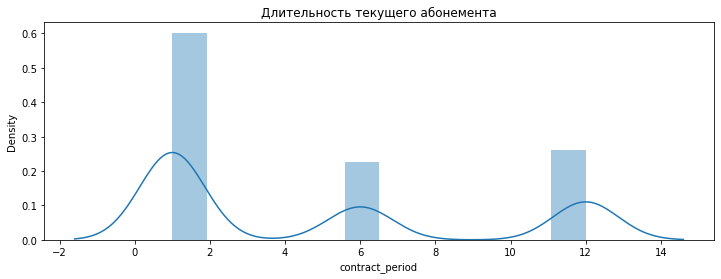

contract_period,1,6,12
0,2207.00,833.00,960.00
0,0.55,0.21,0.24


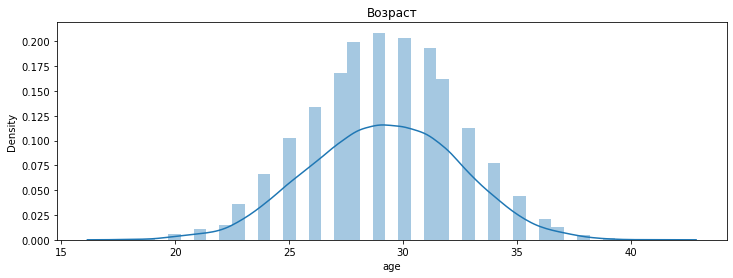

age,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,41
0,2.00,2.00,14.00,24.00,33.00,82.00,148.00,231.00,300.00,378.00,447.00,468.00,457.00,434.00,364.00,253.00,174.00,98.00,48.00,29.00,10.00,3.00,1.00
0,0.00,0.00,0.00,0.01,0.01,0.02,0.04,0.06,0.07,0.09,0.11,0.12,0.11,0.11,0.09,0.06,0.04,0.02,0.01,0.01,0.00,0.00,0.00


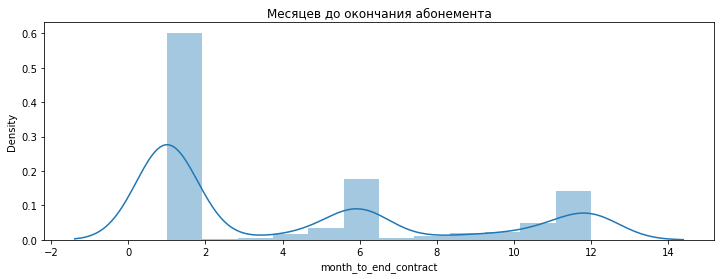

month_to_end_contract,1,2,3,4,5,6,7,8,9,10,11,12
0,2207.00,14.00,23.00,58.00,130.00,645.00,25.00,38.00,73.00,82.00,181.00,524.00
0,0.55,0.00,0.01,0.01,0.03,0.16,0.01,0.01,0.02,0.02,0.05,0.13


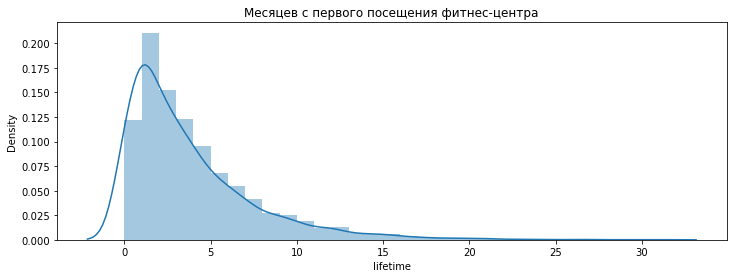

lifetime,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,26,27,29,31
0,487.00,843.00,610.00,490.00,383.00,273.00,220.00,167.00,111.00,100.00,76.00,48.00,53.00,28.00,24.00,24.00,15.00,11.00,7.00,7.00,7.00,5.00,2.00,2.00,2.00,2.00,1.00,1.00,1.00
0,0.12,0.21,0.15,0.12,0.10,0.07,0.06,0.04,0.03,0.03,0.02,0.01,0.01,0.01,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [13]:
# посмотрим на мульти-категориальные признаки

for col in category_cols:
    plt.figure(figsize=(12,4)); 
    plt.title(col_name_dict[col])
    sns.distplot(df[col], bins = int(df[col].max()))
    plt.show()
    display(
        pd.concat([
            df.groupby(col)['churn'].count().to_frame().T.reset_index().drop('index', axis=1),
            (df.groupby(col)['churn'].count()/len(df)).to_frame().T.reset_index().drop('index', axis=1)
        ])
    )

Заметки по графикам:
1. Интересно, что в представленном датасете нет ни одного пользователя, у которого есть абонемент на 3 месяца (только 1 месяц, полгода и год)
2. Средний возраст посетителей - 27-33 года
3. Самый молодой посетитель - 18 лет, самый взрослый - 41 год
4. У большинства пользователей остался всего один-два месяца до окончания абонемента. Это тревожный знак, значит, что много людей покупают абонементы на 1 месяц и могут уйти в "отток" каждый месяц. Рекомендация - больше привлекать людей на более длительные абонементы.
5. Есть очень небольшая группа посетителей, которые пользуются фитнес-центром более года. Вероятно, можно разработать какую-то программу лояльности для удержания большего числа пользователей надолго.

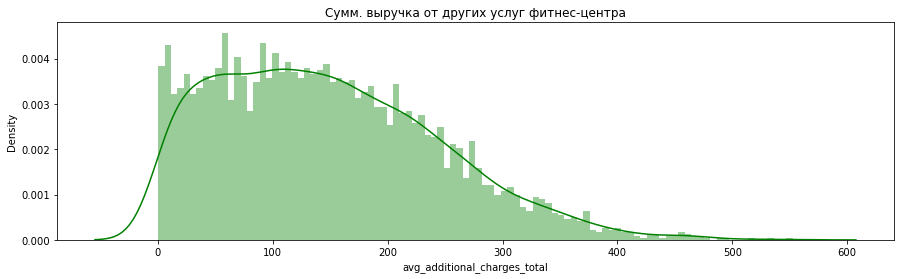

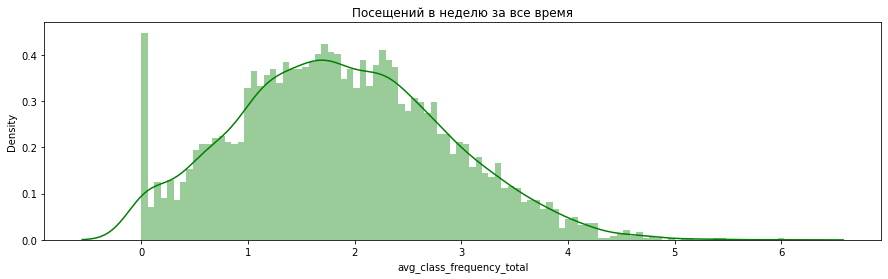

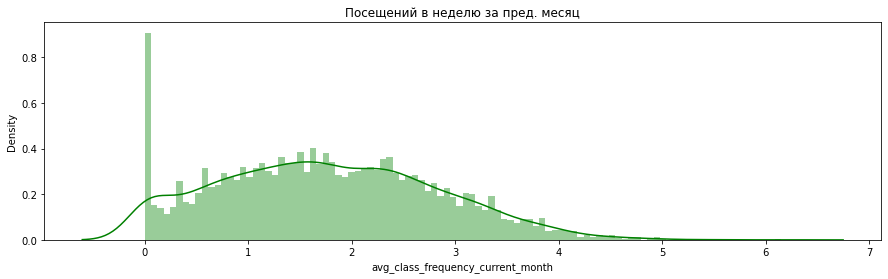

In [14]:
# посмотрим на числовые признаки
for col in numeric_cols:
    plt.figure(figsize=(15,4)); plt.title(col_name_dict[col])
    sns.distplot(df[col], color='green', bins=100)
    plt.show()

Заметки по графикам:
1. Дополнительные услуги фитнес-центра пользуются спросом у подавляющего числа посетителей. Это хорошо.
2. В среднем у посетителей от 1 до 3 посещений в неделю
3. Есть ряд посетителей, у который среднее число посещений в неделю (за последний месц) стремится к нулю. Вероятно, это и есть первые кандидаты на отток, с которыми нужно работать.

### Выводы по шагу 1
    
1. Данные предоставлены подготовленные - нет пропусков, выбросов, некорректных значений.
2. В датасете есть категориальные и числовые признаки
3. Гендерно пользователи фитнес-центра разделены примерно поровну.
4. 85% всех клиентов живут или работают недалеко от фитнес-центра.
5. Половина посетителей фитнес-центра являются сотрудниками компаний-партнёров.
6. 31% новых клиентов изначально приходят по акции "приведи друга"
7. Чуть менее половины пользователей (41%) посещают групповые занятия.
8. Не смотря на описание данных от фитнес-центра, в датасете нет ни одного пользователя с длительностью абонемента 3 месяца (такие абонементы или не популярны, или их нет в продаже).
9. Более половины посетителей (55%) приобрели абонемент на 1 месяц. Это тревожный знак, значит, что много людей могут уйти в "отток" каждый месяц. Рекомендация - больше привлекать людей на более длительные абонементы.
10. Очень небольшая группа клиентов пользуются фитнес-центром более года. Это значит, что либо фитнес-центр открыт не так давно, либо в течение года большая часть клиентов уходит в отток.
11. Подавляющее большинство клиентов приобретают дополнительные услуги фитнес-центра.
12. Среднее число посещений в неделю - от 1 до 3. 
13. Есть группа пользователей со средним числом посещений в неделю =0. Вероятно они уйдут в отток, как только закончится абонемент.
---

## <a id='eda'>Шаг 2 - EDA (Исследовательский анализ данных)</a>

[К оглавлению](#oglav)

### 2.1 <a id='2.1'>Изучение общих данных датасета</a>

In [15]:
# 2.1 Посмотрим на датасет и изучим признаки "глазами"
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00
mean,0.51,0.85,0.49,0.31,0.90,4.68,0.41,29.18,146.94,4.32,3.72,1.88,1.77,0.27
std,0.50,0.36,0.50,0.46,0.30,4.55,0.49,3.26,96.36,4.19,3.75,0.97,1.05,0.44
min,0.00,0.00,0.00,0.00,0.00,1.00,0.00,18.00,0.15,1.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00,1.00,1.00,0.00,27.00,68.87,1.00,1.00,1.18,0.96,0.00
50%,1.00,1.00,0.00,0.00,1.00,1.00,0.00,29.00,136.22,1.00,3.00,1.83,1.72,0.00
75%,1.00,1.00,1.00,1.00,1.00,6.00,1.00,31.00,210.95,6.00,5.00,2.54,2.51,1.00
max,1.00,1.00,1.00,1.00,1.00,12.00,1.00,41.00,552.59,12.00,31.00,6.02,6.15,1.00


Заметки:
1. Гендерное распределение - примерно поровну.
2. Большая часть посетителей (85%) или живёт или работает неподалёку от фитнес-центра (что логично).
3. Чуть меньше половины (49%) посетителей пришли в фитнец-центр от компании-партнёра.
4. По акции "приведи друга" пришли около трети посетителей (31%).
5. Подавляющее число посетителей отсавили свой контактный телефон (90%). Их можно информировать об изменениях в работе и акциях центра. 
    - А где телефоны остальных 10%??? Они что-то скрывают?
6. Средний срок, на который покупают абонементы - это 4,68 месяца. С учётом того, что среди них нет ни одного абонемента на 3 месяца, получается, что очень большую долю занимают абонементы на 1 месяц (которые перевешивают и полугодовые и годовые). 
    - Хорошо ли это? И связано ли это с тем, что половина посетителей - от компаний-партнёров?
7. 40% посетителей занимаются на групповых занятиях. 
    - Связано ли это с тем, что среди посетителей половина - женщины?
8. Средний возраст - 29 лет. (от 18 до 41 года)
9. Интересно, что нет ни одного посетителя, который бы ничего не купил в фитнес-центре дополнительно к абонементу!!! Все что-то покупают.
10. В среднем 4,32 месяца до окончания абонемента. Вероятно, этот признак коррелирует с длительностью абонемента.
11. Средняя длительность посещения фитнес-центра - 3,72 месяца. Маловато. Это говорит о том, что большая текучка клиентов и большая их часть уходит, позанимавшись несколько месяцев. "Старожилов" совсем немного. Либо о том, что недавно прошла эффективная акция по привлечению новых клиентов, поэтому новеньких много!
12. Среднее число посещений в месяц за всё время немного ниже, чем за последний месяц - это говорит о том, что вначале активность у посетителей выше, а со временем снижается.
13. В отток за последний месяц ушло 27% посетителей. Много это или мало - разберёмся позже!

### 2.2 <a id='2.2'>Изучение данных датасета с разбивкой по оттоку</a>

In [16]:
# 2.2 средние значения признаков с разбивкой по оттоку
df.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.51,0.87,0.53,0.35,0.90,5.75,0.46,29.98,158.45,5.28,4.71,2.02,2.03
1,0.51,0.77,0.36,0.18,0.90,1.73,0.27,26.99,115.08,1.66,0.99,1.47,1.04


Заметки по группам оттока:
1. Нет различий по группам по параметрам:
    - пол
    - наличие контактного телефона
2. В отток чаще уходят:
    - те, у кого фитнес-центр находится рядом с домом или работой (кому не нужно добираться до фитнес-центра)
    - самостоятельные посетители, а не клиенты компаний-парнёров (на 17%)
    - те, кто пришёл сам, а не по акции "приведи друга"
    - клиенты с коротким сроком абонемента (соответственно с меньшим сроком до окончания абонемента)
    - посетители, не участвующие в групповых занятиях
    - более молодые посетители
    - те, кто в среднем меньше тратит на дополнительные услуги в фитнес-центре
    - "новенькие" посетители фитнес-центра
    - клиенты с наименьшим средним числом посещений центра в месяц.

In [17]:
# Посмотрим на распределение по числу отточных и неотточных
df['churn'].value_counts().to_frame()#.T

,churn
0,2939
1,1061


In [18]:
df['churn'].value_counts(normalize=True).to_frame().rename(columns={'churn':'churn,%'})#.T # то же в процентах

,"churn,%"
0,0.73
1,0.27


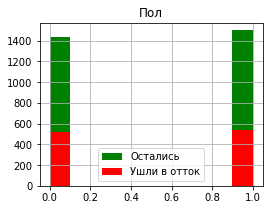

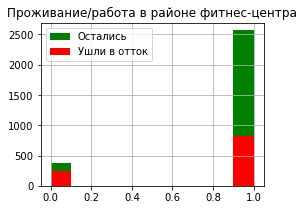

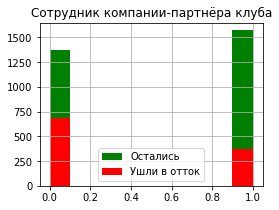

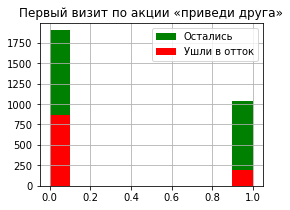

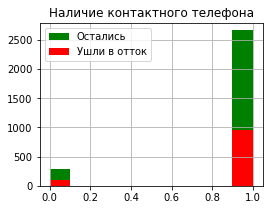

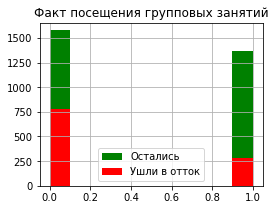

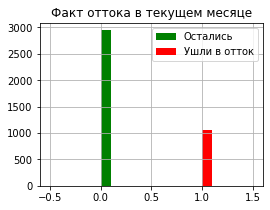

In [19]:
# Соединим вывод гистограмм 0 и 1 на одном поле
for col in binar_cols:
    plt.figure(figsize=(4,3)) 
    plt.title(col_name_dict[col])
#    sns.distplot(df[df['churn']==0][col], label='churn = Flase') # группы оттока не сихнронизируются по оси у!
#    sns.distplot(df[df['churn']==1][col], label='churn = True')
    df[df['churn']==0][col].hist(label='Остались', color='green')
    df[df['churn']==1][col].hist(label='Ушли в отток', color='red')
    plt.legend()
    plt.show();

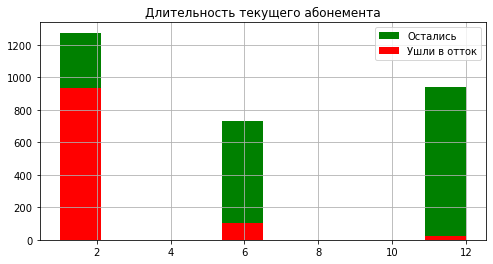

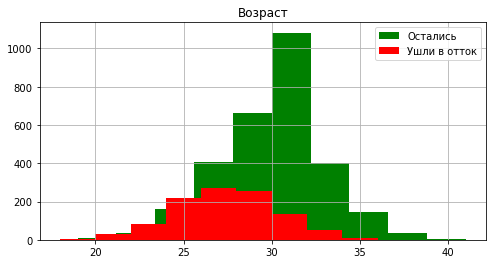

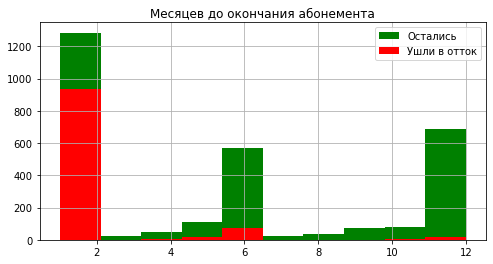

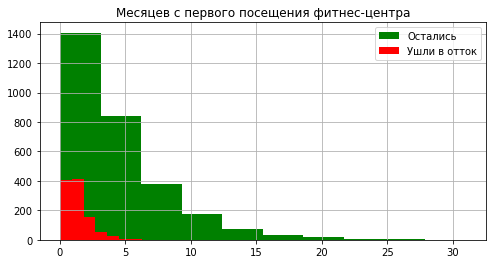

In [20]:
for col in category_cols:
    plt.figure(figsize=(8,4)) 
    plt.title(col_name_dict[col])
    df[df['churn']==0][col].hist(label='Остались', color='green')
    df[df['churn']==1][col].hist(label='Ушли в отток', color='red')
    plt.legend()
    plt.show();

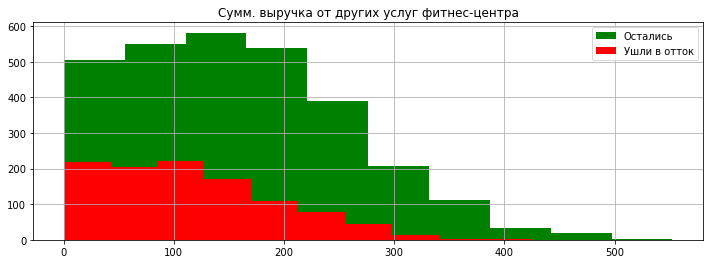

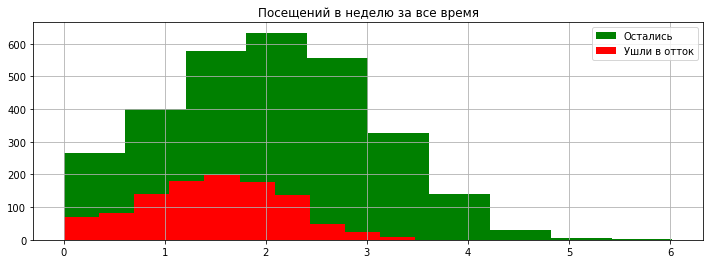

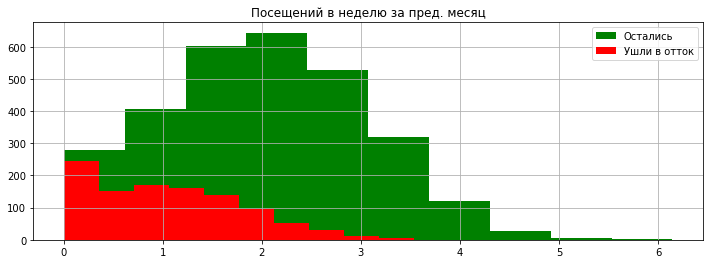

In [21]:
for col in numeric_cols:
    plt.figure(figsize=(12,4)) 
    plt.title(col_name_dict[col])
    df[df['churn']==0][col].hist(label='Остались', color='green')
    df[df['churn']==1][col].hist(label='Ушли в отток', color='red')
    plt.legend()
    plt.show();

#### Выводы по 2.2
1. Из ушедших в отток большинство имело абонемент на 1 месяц.
2. Из ушедних в отток существенная часть клиентов перестала посещать фитнес-центр в последний месяц (среднее число посещений в неделю за последний месяц равна нулю).

### 2.3 <a id='corr_matrix'>Матрица корреляции</a>

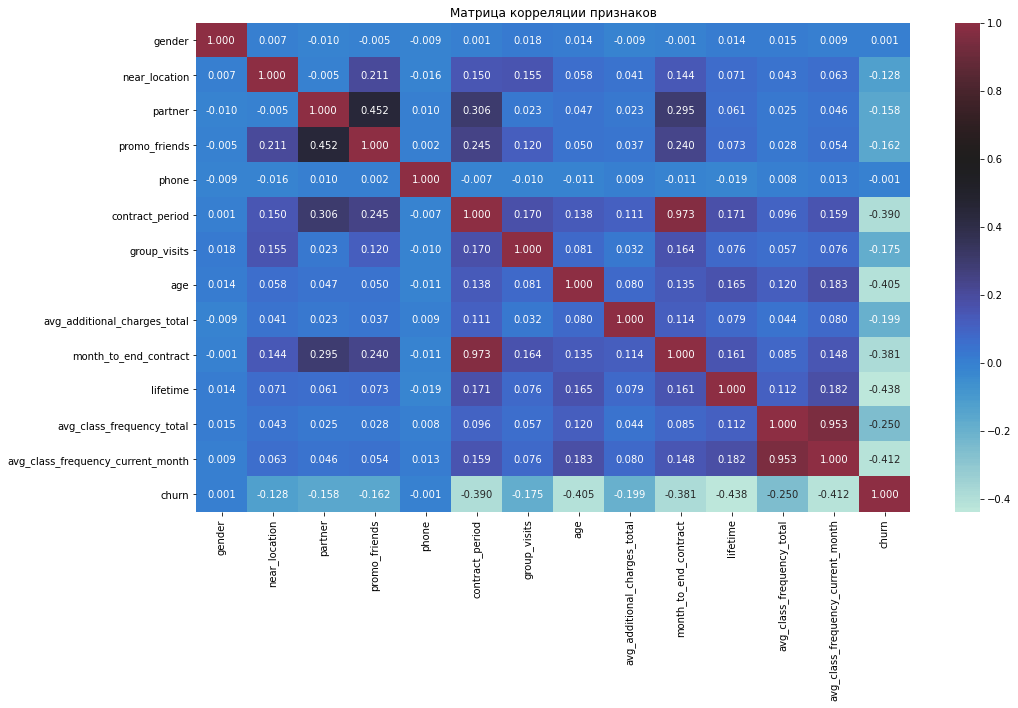

In [22]:
plt.figure(figsize=(16,9))
plt.title('Матрица корреляции признаков')
sns.heatmap(df.corr(), annot=True, fmt='.3f', center=0.6)
plt.show();

**Выводы по матрице корреляции:**
1. Как и предполагалось, высокая корреляция наблюдается между признаками contract_period и month_to_end_contract - аж 97,3%!!!
2. Очень высокая корреляция между средним числом посещений в неделю за весь период и за последний месяц - 95,3%.
3. Достаточно высокая <u>корреляция целевого признака "отток"</u> с такими параметрами, как:
    - lifetime (обратная) -43,8%
    - ср. число посещений в неделю за последний месяц (обратная) -41,2%
    - возраст (обратная) -40,5%
    - длительность абонемента (обратная) -39,0%
    - месяцем до конца абонемента (обратная) -38,1%
4. Странно, что корреляция между оттоком и ср. посещениями за весь период невысокая, тогда как между (оттоком и ср.посещениями за послений месяц) и (ср. посещениями за месяц и за весь период) высокая. Наверное потому, что весь период и последний месяц часто - одно и то же!
5. Уверенная корреляция 45,2% между признаками - поседение по акции "приведи друга" и клиент компании-партнёра (т.е. посетители, которые приходят в фитнес-центр по работе, приглашают своих друзей, которые становятся клиентами, возможно также работая в этой компании).
6. Также наблюдается корреляция между признаками partner и contract_period. Это значит, вероятно, что посетители от компаний-партнёров приобретают абонементы на более длительный срок.
7. Интересно, что признаки "пол" и "наличие контактного телефона" практически не коррелируют с другими признаками и с целевой переменной. Поэтому, вероятно, их <u>можно будет не учитывать</u> в дальнейшем.

### Выводы по шагу 2:
1. Нет различий по группам по параметрам:
    - пол
    - наличие контактного телефона
2. В отток чаще уходят:
    - те, у кого фитнес-центр находится рядом с домом или работой (кому не нужно добираться до фитнес-центра)
    - самостоятельные посетители, а не клиенты компаний-парнёров (на 17%)
    - те, кто пришёл сам, а не по акции "приведи друга"
    - клиенты с коротким сроком абонемента (соответственно с меньшим сроком до окончания абонемента)
    - посетители, не участвующие в групповых занятиях
    - более молодые посетители
    - те, кто в среднем меньше тратит на дополнительные услуги в фитнес-центре
    - "новенькие" посетители фитнес-центра
    - клиенты с наименьшим средним числом посещений центра в месяц.
3. Из ушедших в отток большинство имело абонемент на 1 месяц.
4. Из ушедних в отток существенная часть клиентов перестала посещать фитнес-центр в последний месяц (среднее число посещений в неделю за последний месяц равна нулю).
5. Как и предполагалось, высокая корреляция наблюдается между признаками contract_period и month_to_end_contract - аж 97,3%!!!
6. Очень высокая корреляция между средним числом посещений в неделю за весь период и за последний месяц - 95,3%.
7. Достаточно высокая <u>корреляция целевого признака "отток"</u> с такими параметрами, как:
    - lifetime (обратная) -43,8%
    - ср. число посещений в неделю за последний месяц (обратная) -41,2%
    - возраст (обратная) -40,5%
    - длительность абонемента (обратная) -39,0%
    - месяцем до конца абонемента (обратная) -38,1%
8. Странно, что корреляция между оттоком и ср. посещениями за весь период невысокая, тогда как между (оттоком и ср.посещениями за послений месяц) и (ср. посещениями за месяц и за весь период) высокая. Наверное потому, что весь период и последний месяц часто - одно и то же!
9. Уверенная корреляция 45,2% между признаками - поседение по акции "приведи друга" и клиент компании-партнёра (т.е. посетители, которые приходят в фитнес-центр по работе, приглашают своих друзей, которые становятся клиентами, возможно также работая в этой компании).
10. Также наблюдается корреляция между признаками partner и contract_period. Это значит, вероятно, что посетители от компаний-партнёров приобретают абонементы на более длительный срок.
11. Интересно, что признаки "пол" и "наличие контактного телефона" практически не коррелируют с другими признаками и с целевой переменной. Поэтому, вероятно, их <u>можно будет не учитывать</u> в дальнейшем.
---

## <a id='model'>Шаг 3 - Построение модели прогнозирования оттока пользователей</a>


[К оглавлению](#oglav)

### 3.1 <a id='3.1'>Модель бинарной классификации</a>

In [23]:
# Зададим модели, с которыми будем работать и из которых выбирать лучшую
models = [LogisticRegression(random_state=42), 
          RandomForestClassifier(random_state=42), 
          #DecisionTreeClassifier(), #GradientBoostingClassifier(), #xgboost.XGBClassifier(),
         ]

In [24]:
# отделим целевой признак от всех остальных признаков
X = df.drop('churn', axis=1)
y = df['churn']

1. Избавимя от **gender** и **phone** - т.к. они не коррелируют с целевой переменной.

2. Избавимся от **month_to_end_contract**, т.к. он очень сильно коррелирует с <u>contract_period</u>.

3. !!! Избавляться от <u>avg_class_frequency_total</u> или от <u>avg_class_frequency_current_month</u> не будем, т.к. этот показатель может быть индикатором изменения поведения клиента.

In [25]:
X = df.drop(['churn', 'gender', 'phone', 'month_to_end_contract'], axis=1)
y = df['churn']

### 3.2 <a id='3.2'>Разбивка выборки на обучающую и валидационную</a>

In [26]:
# Так как у нас задача классификации (обучение с учителем), то разобъём выборку на обучающую и вализационную
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# стандартизируем признаки для дальнейшей работы с моделями (train и test подвыборки)
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.fit_transform(X_test)

In [28]:
# стандартизируем признаки для дальнейшей работы с моделями (train и test подвыборки)
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test) # используем transform вместо fit_transform, т.к. мы уже обучили scaler на X_train

### 3.3 <a id='3.3'>Обучение моделей</a>

In [29]:
# зададим функцию прогнозирования, в которую включим вывод интересующих нас метрик
def make_predictions(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train) # обучаем модель
    y_pred = model.predict(X_test)# делаем прогноз
    # считаем метрики - сравниваем прогноз с фактическими значениями из вализационной подвыборки
    print('Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}'.format(accuracy_score(y_test, y_pred), 
                                                                       precision_score(y_test, y_pred), 
                                                                       recall_score(y_test, y_pred)))

### 3.4 <a id='3.4'>Выбор наилучшей модели по метрикам (accuracy, precision, recall)</a>

In [30]:
# прогоняем функцию прогнозирования по всем моделям из списка models и сравниваем метрики
for i in models:
    print(i)
    make_predictions(m=i, X_train=X_train_st, y_train=y_train, X_test=X_test_st, y_test=y_test)
    print()

LogisticRegression(random_state=42)
Accuracy: 0.92, Precision: 0.88, Recall: 0.79

RandomForestClassifier(random_state=42)
Accuracy: 0.92, Precision: 0.88, Recall: 0.80



### Выводы по шагу 3 (после сравнения метрик разных моделей): 
UPD: Судя по метрикам accuracy, precision и recall, модель LogisticRegression даёт более точные предсказания.



---

In [31]:
# немного допилим
def tmp_make_predictions(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train) # обучаем модель
    y_pred = model.predict(X_test)# делаем прогноз
    # считаем метрики - сравниваем прогноз с фактическими значениями из вализационной подвыборки
    print('Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}'.format(accuracy_score(y_test, y_pred), 
                                                                       precision_score(y_test, y_pred), 
                                                                       recall_score(y_test, y_pred)))
    # будем возвращать обученную модель
    return model

In [32]:
for i in models:
    print(i)
    m = tmp_make_predictions(m=i, X_train=X_train_st, y_train=y_train, X_test=X_test_st, y_test=y_test)
    print()
    print(50*'#')
    print("Коэффициенты или важность признаков")
    try:
        display(m.coef_)
    except:
        display(m.feature_importances_)
    print(50*'#')
    print()

LogisticRegression(random_state=42)
Accuracy: 0.92, Precision: 0.88, Recall: 0.79

##################################################
Коэффициенты или важность признаков


array([[-0.09926699, -0.03245459, -0.24134796, -1.29110128, -0.3511115 ,
        -1.13268739, -0.54068929, -3.58438071,  3.37154832, -4.49808471]])

##################################################

RandomForestClassifier(random_state=42)
Accuracy: 0.92, Precision: 0.88, Recall: 0.80

##################################################
Коэффициенты или важность признаков


array([0.00965267, 0.01031098, 0.01213969, 0.11402088, 0.01446451,
       0.12684709, 0.0863803 , 0.29627529, 0.1396201 , 0.19028849])

##################################################



## <a id='cluster'>Шаг 4 - Кластеризация пользователей</a>

[К оглавлению](#oglav)

### 4.1 <a id='4.1'>Уберём целевую переменную из датафрейма</a>

In [33]:
# Задача кластеризации - задача обучения без учителя, поэтому целевая переменная не нужна.
df.drop('churn', axis=1).head(3)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
0,1,1,1,1,0,6,1,29,14.23,5,3,0.02,0.00
1,0,1,0,0,1,12,1,31,113.20,12,7,1.92,1.91
2,0,1,1,0,1,1,0,28,129.45,1,2,1.86,1.74


### 4.2 <a id='4.2'>Cтандартизируем признаки в новом датасете</a>

In [34]:
sc = StandardScaler()
x_sc = sc.fit_transform(df.drop('churn', axis=1))

### 4.3 <a id='4.3'>Построим матрицу расстояний и построим дендрограмму</a>

In [35]:
# 4.3 Построим матрицу расстояний по методу полной связи (межкластерные растояния находим методом Уорда (Ward)) 
# на стандартизированный матрице
linked = linkage(x_sc, method='ward')

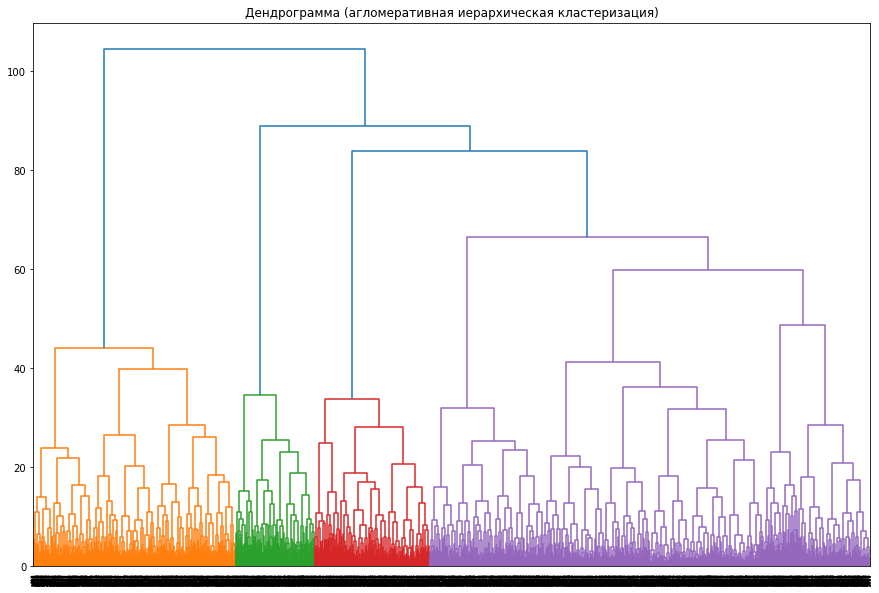

In [36]:
# Выведем дендрограмму как результат кластеризации
plt.figure(figsize=(15,10))
plt.title('Дендрограмма (агломеративная иерархическая кластеризация)')
dendrogram(linked, orientation='top')
plt.show();

#### Вывод по дендрограмме: 
1. Оптимальное число кластеров - 4, исходя из того, что всего в основании дендрограммы 4 цвета (оранжевый, зеленый, красный, фиолетовый)

**Построим дендрограмму на датасете без "лишних" признаков**

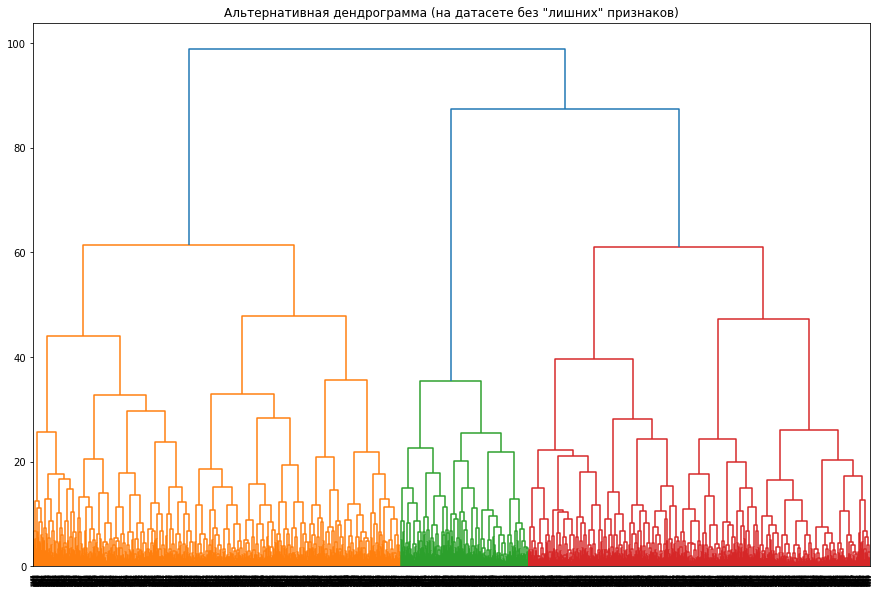

In [37]:
# Попробуем на "облегченных" данных
plt.figure(figsize=(15,10))
plt.title('Альтернативная дендрограмма (на датасете без "лишних" признаков)')
dendrogram(linkage(sc.fit_transform(df.drop(['churn', 'gender', 'phone', 'month_to_end_contract'], 
                                            axis=1)), method='ward'), orientation='top')
plt.show();

<strong>А теперь оптимальным числом кластеров стало 3 вместо 4. Распределение объектов по кластерам, очевидно, стало другим</strong>

### 4.4 <a id='4.4'>Кластеризация K-Means</a>

In [38]:
# 4.4 Кластеризация K-Means (зададим число кластеров =5, как в задании)
km = KMeans(n_clusters=5, random_state=42)

In [39]:
# прогнозируем кластеры для объектов (пользователей)
labels = km.fit_predict(x_sc)

In [40]:
# сохраним метки кластеров в поле датасета dfc
df['cluster_km'] = labels

In [41]:
df.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn,cluster_km
0,1,1,1,1,0,6,1,29,14.23,5,3,0.02,0.00,0,1
1,0,1,0,0,1,12,1,31,113.20,12,7,1.92,1.91,0,4
2,0,1,1,0,1,1,0,28,129.45,1,2,1.86,1.74,0,2
3,0,1,1,1,1,12,1,33,62.67,12,2,3.21,3.36,0,4
4,1,1,1,1,1,1,0,26,198.36,1,3,1.11,1.12,0,2


### 4.5 <a id='4.5'>Посмотрим на средние значения признаков по кластерам K-Means</a>

In [42]:
# 4.5 Посмотрим на средние значения признаков по кластерам
df.groupby('cluster_km').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,,
0,0.50,0.00,0.46,0.08,1.00,2.35,0.22,28.48,135.46,2.20,2.81,1.66,1.48,0.44
1,0.52,0.86,0.47,0.31,0.00,4.79,0.43,29.30,143.96,4.48,3.92,1.85,1.72,0.27
2,0.48,1.00,0.35,0.24,1.00,1.95,0.34,28.17,131.69,1.86,2.43,1.25,1.01,0.51
3,0.56,0.98,0.36,0.24,1.00,2.69,0.47,30.11,161.38,2.48,4.89,2.85,2.85,0.07
4,0.50,0.96,0.78,0.57,1.00,10.92,0.55,29.99,160.88,9.98,4.75,1.98,1.97,0.03


Выводы по средним значениям по кластерам_км:
1. Кластер (3) имеет особенность - наименьшее число пользователей, у которых фитнес-центр находится рядом с домом/работой.
- Кластер (0) - наиболее число пользователей от компаний-партнёров
- Кластер (0) - все пришли по акции "приведи друга"
- Кластеры (1) и (3) - почти нет пришедших по акции "приведи друга"
- Кластер (2) - почти все пользователи имеют абонемент 12 месяцев.
- Кластер (2) - в среднем более 10 месяцев до конца абонемента
- Кластер (1) и (2) - самые давние клиенты
- Кластер (3) - самые "новенькие" клиенты
- Кластер (1) - самое частое посещение фитнес-центра в неделю
- Кластеры (1) и (3) - меньше всего пользователей от компаний-партнёров.
- Отдельно выделен кластер (4), в котором ни у одного пользователя не указан телефон.

### 4.6 <a id='4.6'>Построим графики для кластеров</a>

In [43]:
# 4.6 Построим распределение признаков для кластеров (1 график = 1 признак по всем кластерам)

# Для начала удалим churn из списка колонок 
if 'churn' in binar_cols:
    binar_cols = binar_cols[:-1]
else:
    pass
binar_cols

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'group_visits'],
      dtype='object')

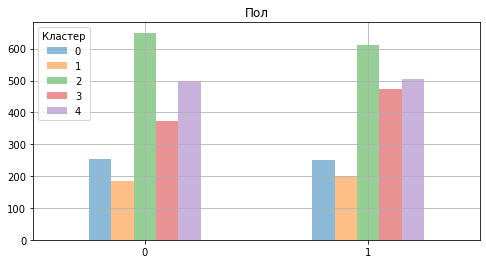

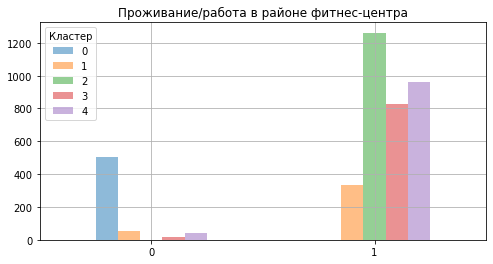

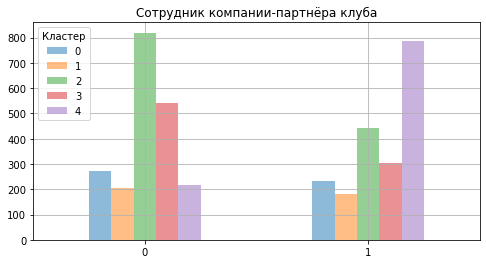

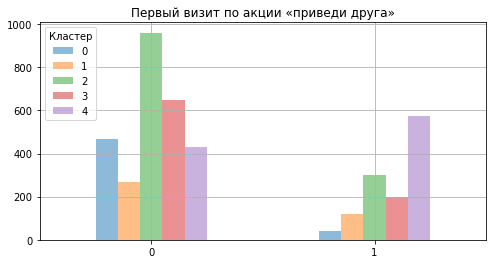

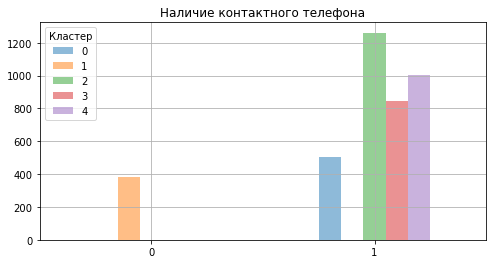

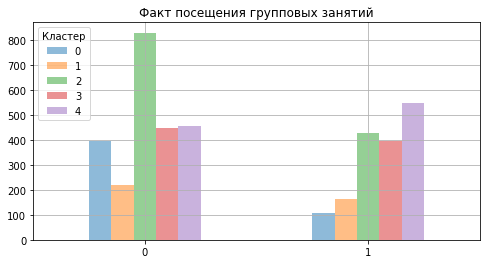

In [44]:
# Построим столбчатую диаграмму для сравнения бинарных признаков по кластерам
for col in binar_cols: 
    df.pivot_table(index=col, columns='cluster_km', 
                   values='age', aggfunc='count').plot.bar(label='Кластер {}'.format(i),
                                                           figsize=(8,4), rot=0, grid=True, alpha=.5)
    plt.title(col_name_dict[col])
    plt.legend(title='Кластер');
    plt.ylabel(''); plt.xlabel('');

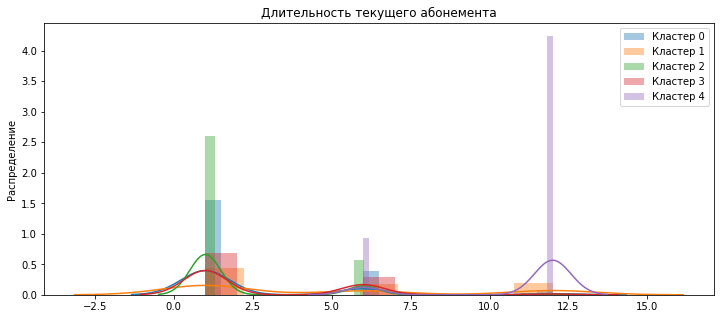

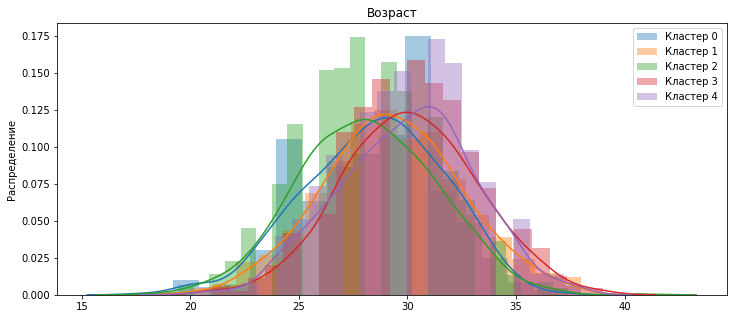

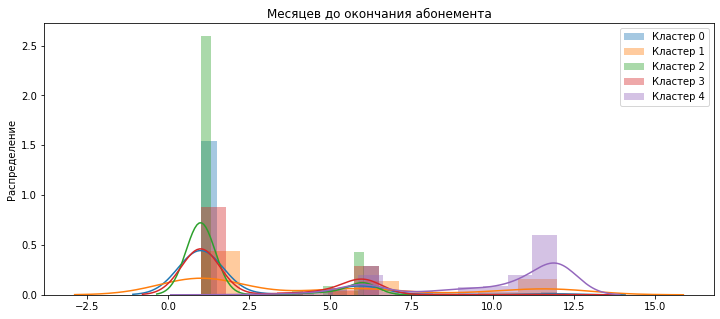

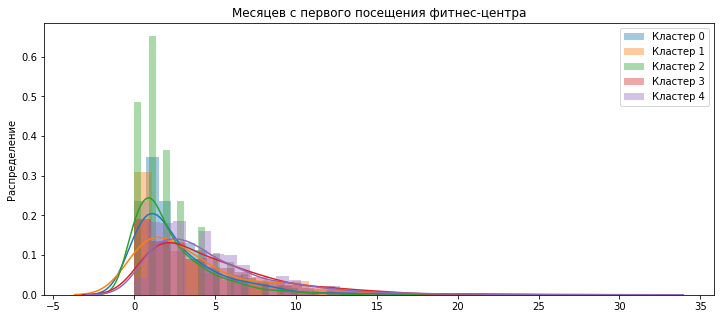

In [45]:
for col in category_cols:
    plt.figure(figsize=(12,5)) 
    plt.title(col_name_dict[col])
    for i in range(0,5):
        sns.distplot(df[df['cluster_km'] == i][col], label='Кластер {}'.format(i))
        plt.legend()
        plt.ylabel('Распределение'); plt.xlabel('')
    plt.show();

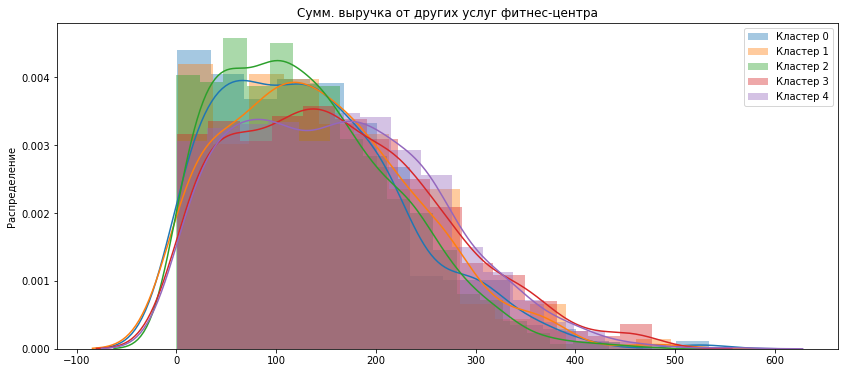

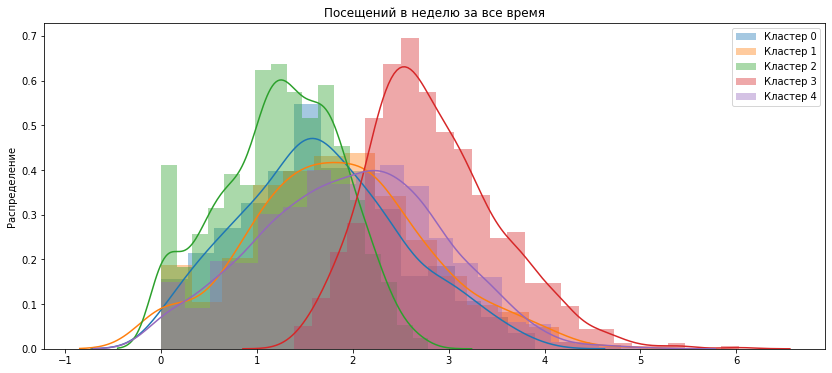

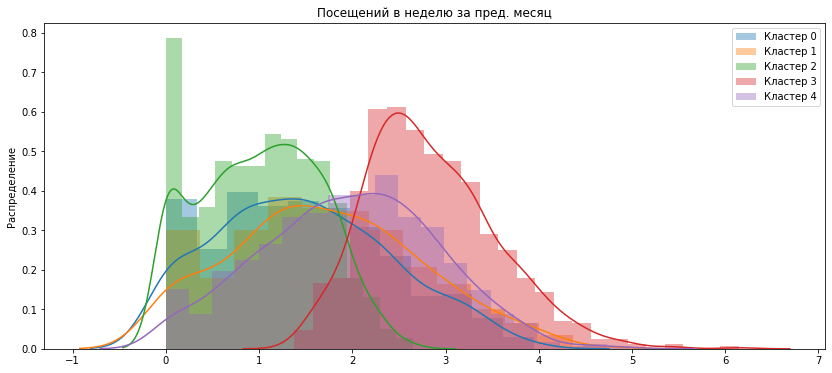

In [46]:
for col in numeric_cols:
    plt.figure(figsize=(14,6)) 
    plt.title(col_name_dict[col])
    for i in range(0,5):
        sns.distplot(df[df['cluster_km'] == i][col], label='Кластер {}'.format(i))
        plt.legend()
        plt.ylabel('Распределение'); plt.xlabel('')
    plt.show();

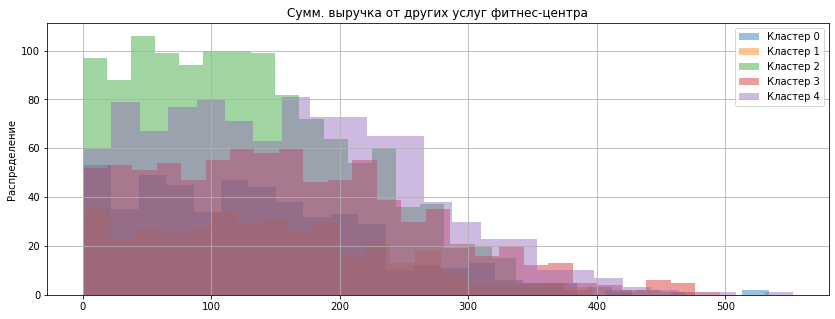

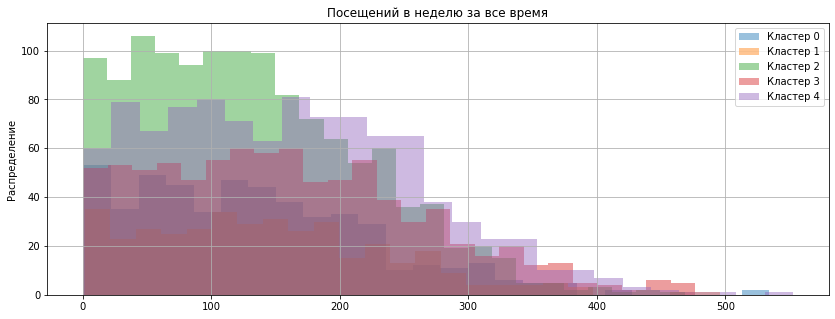

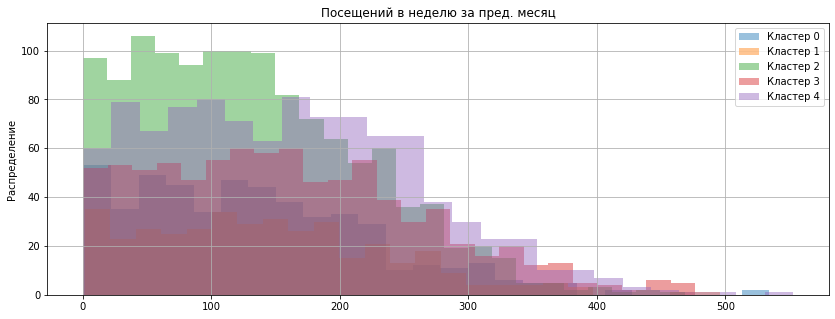

In [47]:
# Выведем то же самое, но теперь в сопоставимом масштабе кластеров между собой
for col in numeric_cols:
    plt.figure(figsize=(14,5)) 
    plt.title(col_name_dict[col])
    for i in range(0,5):
        (df[df['cluster_km'] == i]['avg_additional_charges_total']
             .hist(alpha=.45, bins=25, label='Кластер {}'.format(i)))
        plt.legend()
        plt.ylabel('Распределение'); plt.xlabel('')
    plt.show();

Выводы по графикам:
* Ко всем кластерам
    - пол значения не имеет
    - средний возраст - около 29 лет
    - до окончания абонемента -- пики на 1, 6 и 11 месяцах -- означают, что <i>пользователи только приобрели эти абонементы, т.е. недавно (1-2 месяца назад прошла кампания по привлечению клиентов или был заключен договор с компаниями-партнерам, что привело к притоку клиентов)</i>
    - сумма выручки от дополнительных услуг фитнес-центра более-менее одинакова
    
* Кластер 0 
    - Фитнес-центр не поблизости от дома/работы (нужно добираться)
    - Посетители и от партнёров и самостоятельные
    - В основном не по акции "приведи друга"
    - Контактный телефон указан
    - В основном не посещают групповые занятия
    - В основном покупают абонементы на короткий срок (1 мес)
    - До окончания абонемента 1 - 6 месяцев
    - Месяцев с начала абонемента - от 0 до 3, т.е. приобретены недавно!
    - Среднее число посещений в неделю (за всё время) - 1 раз
    - Среднее число посещений в неделю (за предыдущий месяц) - 1 раз

* Кластер 1
    - Фитнес-центр поблизости от дома/работы
    - Посетители и от партнёров и самостоятельные
    - В основном не по акции "приведи друга"
    - Без контактного телефона
    - Примерно половина посещает групповые занятия
    - Абонементы любой длительности (1 мес - 6 мес - год)
    - До окончания абонемента - любой срок (от 1 до 11 мес)
    - Месяцев с начала абонемента - более пологое распределение от 0 до 12, <i>т.е. отток пользователей более плавный в этом кластере</i>
    - Среднее число посещений в неделю (за всё время) - 2 раза
    - Среднее число посещений в неделю (за предыдущий месяц) - 1 раз (снижение)
    
* Кластер 2
    - Фитнес-центр поблизости от дома/работы
    - Посетители и от партнёров и самостоятельные
    - В основном не по акции "приведи друга"
    - Контактный телефон указан
    - Примерно половина посещает групповые занятия
    - В основном покупают абонементы на короткий срок (1 мес - 6 мес)
    - До окончания абонемента 1 - 6 месяцев
    - Месяцев с начала абонемента - от 0 до 3, т.е. приобретены недавно!
    - Среднее число посещений в неделю (за всё время) - 1 раз (причём существенная часть пользователей - 0 раз)
    - Среднее число посещений в неделю (за предыдущий месяц) - 1 раз, с большим числом пользователей - 0 раз!

* Кластер 3
    - Фитнес-центр поблизости от дома/работы
    - Посетители и от партнёров и самостоятельные
    - В основном не по акции "приведи друга"
    - Контактный телефон указан
    - Примерно половина посещает групповые занятия
    - В основном покупают абонементы на короткий срок (1 мес - 6 мес)
    - До окончания абонемента 1 - 6 месяцев
    - Месяцев с начала абонемента - более пологое распределение от 0 до 12, <i>т.е. отток пользователей более плавный в этом кластере</i>
    - Среднее число посещений в неделю (за всё время) - 2-3 раза
    - Среднее число посещений в неделю (за предыдущий месяц) - 2-4 раза

* Кластер 4
    - Фитнес-центр поблизости от дома/работы
    - В основном сотрудники компаний-партнёров
    - В основном не по акции "приведи друга"
    - Контактный телефон указан
    - Примерно половина посещает групповые занятия
    - В основном покупают длительные абонементы (6 мес - год)
    - До окончания абонемента 6 - 11 месяцев
    - Месяцев с начала абонемента - более пологое распределение от 0 до 12, <i>т.е. отток пользователей более плавный в этом кластере</i>
    - Среднее число посещений в неделю (за всё время) - 2 раза
    - Среднее число посещений в неделю (за предыдущий месяц) - 2 раза.

### 4.7 <a id='4.7'>Доли оттока для кластеров</a>

In [48]:
# 4.7 Для каждого полученного кластера посчитайте долю оттока (методом groupby()). 
# Отличаются ли они по доле оттока? Какие кластеры склонны к оттоку, а какие — надёжны?

df.groupby('cluster_km')['churn'].mean().to_frame().rename(columns={'churn':'churn_mean'}).T

cluster_km,0,1,2,3,4
churn_mean,0.44,0.27,0.51,0.07,0.03


Выводы:
1. Наибольшие доли оттока - в Кластере-2 (51%) и Кластере-0 (44%) - самые ненадёжные.
2. Наименьшие доли оттока - в Кластере-4 (3%) и Кластере-3 (7%) - самые надёжные.
3. Кластер-1 имеет среднюю долю оттока (27%), <i>но на него нужно также обратить внимание, поскольку было выявлено снижение среднего числа посещений в неделю за предыдущий месяц относительно всего периода действия абонемента.</i>

### Выводы по шагу 4:
Характериные признаки для кластеров:
* Для всех кластеров:
    - пол значения не имеет
    - средний возраст - около 29 лет
    - до окончания абонемента -- пики на 1, 6 и 11 месяцах -- означают, что <i>пользователи только приобрели эти абонементы, т.е. недавно (1-2 месяца назад прошла кампания по привлечению клиентов или был заключен договор с компаниями-партнерам, что привело к притоку клиентов)</i>
    - сумма выручки от дополнительных услуг фитнес-центра более-менее одинакова
    
* Кластер 0 
    - Фитнес-центр не поблизости от дома/работы (нужно добираться)
    - Посетители и от партнёров и самостоятельные
    - В основном не по акции "приведи друга"
    - Контактный телефон указан
    - В основном не посещают групповые занятия
    - В основном покупают абонементы на короткий срок (1 мес)
    - До окончания абонемента 1 - 6 месяцев
    - Месяцев с начала абонемента - от 0 до 3, т.е. приобретены недавно!
    - Среднее число посещений в неделю (за всё время) - 1 раз
    - Среднее число посещений в неделю (за предыдущий месяц) - 1 раз

* Кластер 1
    - Фитнес-центр поблизости от дома/работы
    - Посетители и от партнёров и самостоятельные
    - В основном не по акции "приведи друга"
    - Без контактного телефона
    - Примерно половина посещает групповые занятия
    - Абонементы любой длительности (1 мес - 6 мес - год)
    - До окончания абонемента - любой срок (от 1 до 11 мес)
    - Месяцев с начала абонемента - более пологое распределение от 0 до 12, <i>т.е. отток пользователей более плавный в этом кластере</i>
    - Среднее число посещений в неделю (за всё время) - 2 раза
    - Среднее число посещений в неделю (за предыдущий месяц) - 1 раз (снижение)
    
* Кластер 2
    - Фитнес-центр поблизости от дома/работы
    - Посетители и от партнёров и самостоятельные
    - В основном не по акции "приведи друга"
    - Контактный телефон указан
    - Примерно половина посещает групповые занятия
    - В основном покупают абонементы на короткий срок (1 мес - 6 мес)
    - До окончания абонемента 1 - 6 месяцев
    - Месяцев с начала абонемента - от 0 до 3, т.е. приобретены недавно!
    - Среднее число посещений в неделю (за всё время) - 1 раз (причём существенная часть пользователей - 0 раз)
    - Среднее число посещений в неделю (за предыдущий месяц) - 1 раз, с большим числом пользователей - 0 раз!

* Кластер 3
    - Фитнес-центр поблизости от дома/работы
    - Посетители и от партнёров и самостоятельные
    - В основном не по акции "приведи друга"
    - Контактный телефон указан
    - Примерно половина посещает групповые занятия
    - В основном покупают абонементы на короткий срок (1 мес - 6 мес)
    - До окончания абонемента 1 - 6 месяцев
    - Месяцев с начала абонемента - более пологое распределение от 0 до 12, <i>т.е. отток пользователей более плавный в этом кластере</i>
    - Среднее число посещений в неделю (за всё время) - 2-3 раза
    - Среднее число посещений в неделю (за предыдущий месяц) - 2-4 раза

* Кластер 4
    - Фитнес-центр поблизости от дома/работы
    - В основном сотрудники компаний-партнёров
    - В основном не по акции "приведи друга"
    - Контактный телефон указан
    - Примерно половина посещает групповые занятия
    - В основном покупают длительные абонементы (6 мес - год)
    - До окончания абонемента 6 - 11 месяцев
    - Месяцев с начала абонемента - более пологое распределение от 0 до 12, <i>т.е. отток пользователей более плавный в этом кластере</i>
    - Среднее число посещений в неделю (за всё время) - 2 раза
    - Среднее число посещений в неделю (за предыдущий месяц) - 2 раза.
    
    
1. Наибольшие доли оттока - в Кластере-2 (51%) и Кластере-0 (44%) - самые ненадёжные.
2. Наименьшие доли оттока - в Кластере-4 (3%) и Кластере-3 (7%) - самые надёжные.
3. Кластер-1 имеет среднюю долю оттока (27%), <i>но на него нужно также обратить внимание, поскольку было выявлено снижение среднего числа посещений в неделю за предыдущий месяц относительно всего периода действия абонемента.</i>
---

## <a id='resume'>Шаг 5 - Выводы и рекомендации</a>

[К оглавлению](#oglav)

### Подробные выводы по всем шагам

**Выводы по шагу 1:**
1. Данные предоставлены подготовленные - нет пропусков, выбросов, некорректных значений.
2. В датасете есть категориальные и числовые признаки
3. Гендерно пользователи фитнес-центра разделены примерно поровну.
4. 85% всех клиентов живут или работают недалеко от фитнес-центра.
5. Половина посетителей фитнес-центра являются сотрудниками компаний-партнёров.
6. 31% новых клиентов изначально приходят по акции "приведи друга"
7. Чуть менее половины пользователей (41%) посещают групповые занятия.
8. Не смотря на описание данных от фитнес-центра, в датасете нет ни одного пользователя с длительностью абонемента 3 месяца (такие абонементы или не популярны, или их нет в продаже).
9. Более половины посетителей (55%) приобрели абонемент на 1 месяц. Это тревожный знак, значит, что много людей могут уйти в "отток" каждый месяц. Рекомендация - больше привлекать людей на более длительные абонементы.
10. Очень небольшая группа клиентов пользуются фитнес-центром более года. Это значит, что либо фитнес-центр открыт не так давно, либо в течение года большая часть клиентов уходит в отток.
11. Подавляющее большинство клиентов приобретают дополнительные услуги фитнес-центра.
12. Среднее число посещений в неделю - от 1 до 3. 
13. Есть группа пользователей со средним числом посещений в неделю =0. Вероятно они уйдут в отток, как только закончится абонемент.


**Выводы по шагу 2:**
1. Нет различий по группам по параметрам:
    - пол
    - наличие контактного телефона
2. В отток чаще уходят:
    - те, у кого фитнес-центр находится рядом с домом или работой (кому не нужно добираться до фитнес-центра)
    - самостоятельные посетители, а не клиенты компаний-парнёров (на 17%)
    - те, кто пришёл сам, а не по акции "приведи друга"
    - клиенты с коротким сроком абонемента (соответственно с меньшим сроком до окончания абонемента)
    - посетители, не участвующие в групповых занятиях
    - более молодые посетители
    - те, кто в среднем меньше тратит на дополнительные услуги в фитнес-центре
    - "новенькие" посетители фитнес-центра
    - клиенты с наименьшим средним числом посещений центра в месяц.
3. Из ушедших в отток большинство имело абонемент на 1 месяц.
4. Из ушедних в отток существенная часть клиентов перестала посещать фитнес-центр в последний месяц (среднее число посещений в неделю за последний месяц равна нулю).
5. Как и предполагалось, высокая корреляция наблюдается между признаками contract_period и month_to_end_contract - аж 97,3%!!!
6. Очень высокая корреляция между средним числом посещений в неделю за весь период и за последний месяц - 95,3%.
7. Достаточно высокая <u>корреляция целевого признака "отток"</u> с такими параметрами, как:
    - lifetime (обратная) -43,8%
    - ср. число посещений в неделю за последний месяц (обратная) -41,2%
    - возраст (обратная) -40,5%
    - длительность абонемента (обратная) -39,0%
    - месяцем до конца абонемента (обратная) -38,1%
8. Странно, что корреляция между оттоком и ср. посещениями за весь период невысокая, тогда как между (оттоком и ср.посещениями за послений месяц) и (ср. посещениями за месяц и за весь период) высокая. Наверное потому, что весь период и последний месяц часто - одно и то же!
9. Уверенная корреляция 45,2% между признаками - поседение по акции "приведи друга" и клиент компании-партнёра (т.е. посетители, которые приходят в фитнес-центр по работе, приглашают своих друзей, которые становятся клиентами, возможно также работая в этой компании).
10. Также наблюдается корреляция между признаками partner и contract_period. Это значит, вероятно, что посетители от компаний-партнёров приобретают абонементы на более длительный срок.
11. Интересно, что признаки "пол" и "наличие контактного телефона" практически не коррелируют с другими признаками и с целевой переменной. Поэтому, вероятно, их <u>можно будет не учитывать</u> в дальнейшем.


**Выводы по шагу 3 (после сравнения метрик разных моделей): **
1. Судя по метрикам accuracy и recall, модель LogisticRegression даёт более точные предсказания.
2. Метрика precision показала одинаковый результат на обеих моделях.


**Выводы по шагу 4:**

Характериные признаки для кластеров:
* Для всех кластеров:
    - пол значения не имеет
    - средний возраст - около 29 лет
    - до окончания абонемента -- пики на 1, 6 и 11 месяцах -- означают, что <i>пользователи только приобрели эти абонементы, т.е. недавно (1-2 месяца назад прошла кампания по привлечению клиентов или был заключен договор с компаниями-партнерам, что привело к притоку клиентов)</i>
    - сумма выручки от дополнительных услуг фитнес-центра более-менее одинакова
    
* Кластер 0 
    - Фитнес-центр не поблизости от дома/работы (нужно добираться)
    - Посетители и от партнёров и самостоятельные
    - В основном не по акции "приведи друга"
    - Контактный телефон указан
    - В основном не посещают групповые занятия
    - В основном покупают абонементы на короткий срок (1 мес)
    - До окончания абонемента 1 - 6 месяцев
    - Месяцев с начала абонемента - от 0 до 3, т.е. приобретены недавно!
    - Среднее число посещений в неделю (за всё время) - 1 раз
    - Среднее число посещений в неделю (за предыдущий месяц) - 1 раз

* Кластер 1
    - Фитнес-центр поблизости от дома/работы
    - Посетители и от партнёров и самостоятельные
    - В основном не по акции "приведи друга"
    - Без контактного телефона
    - Примерно половина посещает групповые занятия
    - Абонементы любой длительности (1 мес - 6 мес - год)
    - До окончания абонемента - любой срок (от 1 до 11 мес)
    - Месяцев с начала абонемента - более пологое распределение от 0 до 12, <i>т.е. отток пользователей более плавный в этом кластере</i>
    - Среднее число посещений в неделю (за всё время) - 2 раза
    - Среднее число посещений в неделю (за предыдущий месяц) - 1 раз (снижение)
    
* Кластер 2
    - Фитнес-центр поблизости от дома/работы
    - Посетители и от партнёров и самостоятельные
    - В основном не по акции "приведи друга"
    - Контактный телефон указан
    - Примерно половина посещает групповые занятия
    - В основном покупают абонементы на короткий срок (1 мес - 6 мес)
    - До окончания абонемента 1 - 6 месяцев
    - Месяцев с начала абонемента - от 0 до 3, т.е. приобретены недавно!
    - Среднее число посещений в неделю (за всё время) - 1 раз (причём существенная часть пользователей - 0 раз)
    - Среднее число посещений в неделю (за предыдущий месяц) - 1 раз, с большим числом пользователей - 0 раз!

* Кластер 3
    - Фитнес-центр поблизости от дома/работы
    - Посетители и от партнёров и самостоятельные
    - В основном не по акции "приведи друга"
    - Контактный телефон указан
    - Примерно половина посещает групповые занятия
    - В основном покупают абонементы на короткий срок (1 мес - 6 мес)
    - До окончания абонемента 1 - 6 месяцев
    - Месяцев с начала абонемента - более пологое распределение от 0 до 12, <i>т.е. отток пользователей более плавный в этом кластере</i>
    - Среднее число посещений в неделю (за всё время) - 2-3 раза
    - Среднее число посещений в неделю (за предыдущий месяц) - 2-4 раза

* Кластер 4
    - Фитнес-центр поблизости от дома/работы
    - В основном сотрудники компаний-партнёров
    - В основном не по акции "приведи друга"
    - Контактный телефон указан
    - Примерно половина посещает групповые занятия
    - В основном покупают длительные абонементы (6 мес - год)
    - До окончания абонемента 6 - 11 месяцев
    - Месяцев с начала абонемента - более пологое распределение от 0 до 12, <i>т.е. отток пользователей более плавный в этом кластере</i>
    - Среднее число посещений в неделю (за всё время) - 2 раза
    - Среднее число посещений в неделю (за предыдущий месяц) - 2 раза.
    
1. Наибольшие доли оттока - в Кластере-2 (51%) и Кластере-0 (44%) - самые ненадёжные.
2. Наименьшие доли оттока - в Кластере-4 (3%) и Кластере-3 (7%) - самые надёжные.
3. Кластер-1 имеет среднюю долю оттока (27%), <i>но на него нужно также обратить внимание, поскольку было выявлено снижение среднего числа посещений в неделю за предыдущий месяц относительно всего периода действия абонемента.</i>

---

### Общие выводы:
1. Более половины посетителей (55%) приобрели абонемент на 1 месяц. Это тревожный знак, значит, что много людей могут уйти в "отток" каждый месяц. Рекомендация - больше привлекать людей на более длительные абонементы.
2. Очень небольшая группа клиентов пользуются фитнес-центром более года. Это значит, что либо фитнес-центр открыт не так давно, либо в течение года большая часть клиентов уходит в отток.
3. Есть группа пользователей со средним числом посещений в неделю =0. Вероятно они уйдут в отток, как только закончится абонемент.
4. В отток чаще уходят:
    - самостоятельные посетители, а не клиенты компаний-парнёров (на 17%)
    - те, кто пришёл сам, а не по акции "приведи друга"
    - клиенты с коротким сроком абонемента
    - посетители, не участвующие в групповых занятиях
    - более молодые посетители
    - те, кто в среднем меньше тратит на дополнительные услуги в фитнес-центре
    - "новенькие" посетители фитнес-центра
    - клиенты с наименьшим средним числом посещений центра в месяц.
5. Из ушедших в отток большинство имело абонемент на 1 месяц.
6. Из ушедних в отток существенная часть клиентов перестала посещать фитнес-центр в последний месяц (среднее число посещений в неделю за последний месяц равно нулю).
7. Достаточно высокая обратная корреляция целевого признака "отток" с такими параметрами, как:
    - lifetime -43,8%
    - ср. число посещений в неделю за последний месяц -41,2%
    - возраст -40,5%
    - длительность абонемента -39,0%
    - месяцем до конца абонемента -38,1%
8. Уверенная корреляция 45,2% между признаками - поседение по акции "приведи друга" и клиент компании-партнёра.
9. Судя по метрикам, модель Логистической регрессии даёт более точные предсказания.
10. Всех клиентов можно разделить на 5 кластеров (оптимально на 4!) со следующими характерными признаками:

* Кластер 0 
    - Фитнес-центр далеко от дома/работы
    - Занимаются индивидуально (не посещают групповые занятия)
    - Абонементы на короткий срок (1 месяц)
    - Месяцев с начала абонемента - от 0 до 3, т.е. приобретены недавно!
    - Среднее число посещений в неделю - 1 раз
    - Вероятность оттока - 44%

* Кластер 1
    - Фитнес-центр поблизости от дома/работы
    - Без контактного телефона
    - Стабильный кластер - регулярно появляются новые клиенты, плавный отток
    - Среднее число посещений в неделю - 2 раза (при этом снижается)
    - Вероятность оттока - 27%
    
* Кластер 2
    - Фитнес-центр поблизости от дома/работы
    - Абонементы на короткий срок (1 мес - 6 мес)
    - Месяцев с начала абонемента - от 0 до 3, т.е. приобретены недавно!
    - Среднее число посещений в неделю - 1 раз (причём существенная часть пользователей - 0 раз)
    - Вероятность оттока - 51% (самый ненадёжный кластер!)

* Кластер 3
    - Фитнес-центр поблизости от дома/работы
    - Абонементы на короткий срок (1 мес - 6 мес)
    - Стабильный кластер - регулярно появляются новые клиенты, плавный отток
    - Среднее число посещений в неделю - 2-4 раза
    - Вероятность оттока - 7%

* Кластер 4
    - Фитнес-центр поблизости от дома/работы
    - Сотрудники компаний-партнёров
    - Длительные абонементы (6 мес - 1 год)
    - Стабильный кластер - регулярно появляются новые клиенты, плавный отток
    - Среднее число посещений в неделю - 2 раза
    - Вероятность оттока - 3% (самый надёжный кластер!)

### Рекомендации:
1. Следить за показателем среднего числа посещений в неделю. Если есть тенденция к снижению за последний месяц, то этот клиент - потенциальный кандидат уйти в отток.
2. Стараться предлагать посетителям абонементы с более длительным сроком. Чем ниже срок абонемента, тем выше вероятность, что пользователь уйдёт в отток. Проработать ценовую стратегию. В том числе перевести часть клиентов с месячного абонемента на трёхмесячный или полугодовой.
3. Систематически проводить акции по привлечению клиентов (тогда отток будет более плавным), а также точнее выбирать целевую аудиторию, исходя из характерных признаков кластеров 4 и 3.
5. Хорошо показала себя стратегия привлечения посетителей через компании-партнеров. Продолжать проработка компаний неподалёку от фитнес-центра.